# Predict 1-log and 6-log Reduction Dose of Ciprofloxacin

In [7]:
import os

import arviz as az
import chi
import chi.plots
import matplotlib.transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pints
import plotly.graph_objects as go
import plotly.colors
import seaborn as sns
from tqdm.notebook import tqdm
import xarray as xr

Define convenience functions.

In [39]:
def format_posterior(posterior, param_names, name_map):
    """
    Returns posterior samples as numpy.ndarray.
    """
    n_chains = len(posterior.chain.values)
    n_draws = len(posterior.draw.values)
    n_parameters = len(posterior)
    numpy_posterior = np.empty(shape=(n_chains * n_draws, n_parameters))
    param_names = [name_map[name] for name in param_names]
    for param_id, param in enumerate(param_names):
        # Get samples as numpy array
        samples = posterior[param].values

        # Flatten samples and make sure order is preserved
        numpy_posterior[:, param_id] = samples.flatten()

    return numpy_posterior

def load_inference_data(models, model_names, name_map, end_experiment):
    """
    Returns the posterior samples and the model likelihoods. The posterior
    samples for each model are formatted as numpy.ndarray of shape
    (n_samples, n_parameters).
    """
    n_models = len(models)
    aic_scores = np.empty(shape=n_models)
    parameters = []
    directory = os.getcwd()
    for id_m, model in enumerate(model_names):
        # Load inference data
        inf_data = xr.load_dataset(
            directory + '/derived_data/%s_posterior_%dh.nc'
            % (model, int(end_experiment))
        )
        names = models[id_m].parameters() + ['Sigma log']
        parameters.append(format_posterior(inf_data, names, name_map[id_m]))
        aic_scores[id_m] = inf_data.attrs['AIC score']

    # Compute elpd deltas to avoid numerical overflow
    aic_scores -= np.min(aic_scores)

    # Compute weights
    weights = np.exp(-aic_scores / 2) / np.sum(np.exp(-aic_scores / 2))

    return parameters, weights

In [38]:
directory = os.getcwd()
inf_data = xr.load_dataset(
    directory + '/derived_data/KR_model_posterior_10h.nc')
inf_data['pooled_adapted_ec50']

<xarray.DataArray 'pooled_adapted_ec50' (chain: 5, draw: 4000)>
array([[550.52522573, 550.52522573, 374.85970112, ..., 854.40980801,
        829.33336876, 829.33336876],
       [717.59762857, 484.69758628, 935.63682064, ..., 831.67896264,
        831.67896264, 844.68039764],
       [557.8499874 , 519.96307155, 379.75795071, ..., 440.01373948,
        629.07174985, 234.59748476],
       [557.03835088, 830.83935544, 558.98376414, ..., 583.35761812,
        853.75166824, 271.03526437],
       [796.3935048 , 502.05397564, 679.83217597, ..., 975.86929096,
        501.95892967, 600.71099481]])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4
  * draw     (draw) int64 10000 10010 10020 10030 ... 49960 49970 49980 49990

## Show data

In [5]:
# Get data
directory = os.getcwd()
data = pd.read_csv(directory + '/derived_data/measurements.csv')

# Create scatter plots of data
fig = chi.plots.PDTimeSeriesPlot()
fig.add_data(data, biomarker='Bacterial count')
fig.set_axis_labels(xlabel='Time in hours', ylabel='Bacterial count in CFU/mL')
fig.show()

## Define candidate models

Recall that the data-generating model is the KR model.
We will use the data-generating model (with the true model parameters) as a
reference to evaluate the reliability of the model predictions.

In [6]:
# Define K model
directory = os.path.dirname(os.path.dirname(os.getcwd()))
k_model = chi.PharmacokineticModel(directory + '/models/K_model.xml')
k_model.set_administration(compartment='central')
k_model.set_parameter_names(names={
    'myokit.bacterial_count': 'Initial bacterial count in CFU/ml',
    'myokit.concentration_e50': 'EC 50 in ng/ml',
    'myokit.growth_rate': 'Growth rate in 1/h',
    'myokit.kappa': 'Max. kill rate in 1/h'})
k_model.set_outputs(['myokit.bacterial_count'])
k_model.set_output_names({
    'myokit.bacterial_count': 'Bacterial count in CFU/ml'})
k_model = chi.ReducedMechanisticModel(
    k_model)
k_model.fix_parameters({
    'central.drug_amount': 0,
    'dose.drug_amount': 0,
    'myokit.bacterial_count_adapted': 0,
    'dose.absorption_rate': 2.7,           # in 1/h, Sanchez et al
    'central.size': 3.7 * 70,              # in L/kg, Sanchez et al for 70 kg
    'myokit.elimination_rate': 0.17,       # in 1/h, Sanchez et al
    'myokit.gamma': 1})


# Define KP model
kp_model = chi.PharmacokineticModel(directory + '/models/KP_model.xml')
kp_model.set_administration(compartment='central', direct=False)
kp_model.set_parameter_names(names={
    'myokit.bacterial_count_susceptible': 'Initial bacterial count in CFU/ml',
    'myokit.death_rate': 'Death rate in 1/h',
    'myokit.growth_rate': 'Growth rate in 1/h',
    'myokit.kappa': 'Kill rate in ml/ng/h',
    'myokit.transition_rate_12': 'Transition rate to dividing in 1/h',
    'myokit.transition_rate_21': 'Transition rate to non-dividing in ml/ng/h'})
kp_model.set_outputs(['myokit.total_bacterial_count'])
kp_model.set_output_names({
    'myokit.total_bacterial_count': 'Bacterial count in CFU/ml'})
kp_model = chi.ReducedMechanisticModel(
    kp_model)
kp_model.fix_parameters({
    'central.drug_amount': 0,
    'dose.drug_amount': 0,
    'myokit.bacterial_count_adapted': 0,
    'dose.absorption_rate': 2.7,           # in 1/h, Sanchez et al
    'central.size': 3.7 * 70,              # in L/kg, Sanchez et al for 70 kg
    'myokit.elimination_rate': 0.17,       # in 1/h, Sanchez et al
    'myokit.gamma': 1})

# Define KR model
kr_model = chi.PharmacokineticModel(directory + '/models/KR_model.xml')
kr_model.set_administration(compartment='central', direct=False)
kr_model.set_parameter_names(names={
    'myokit.bacterial_count_susceptible': 'Initial bacterial count in CFU/ml',
    'myokit.concentration_e50_adapted': 'Adapted EC 50 in ng/ml',
    'myokit.growth_rate': 'Growth rate in 1/h',
    'myokit.kappa_adapted': 'Adapted max. kill rate in 1/h',
    'myokit.kappa_susceptible': 'Wild type kill rate in ml/ng/h',
    'myokit.mutation_rate': 'Mutation rate in ml/ng/h'})
kr_model.set_outputs(['myokit.total_bacterial_count'])
kr_model.set_output_names({
    'myokit.total_bacterial_count': 'Bacterial count in CFU/ml'})
kr_model = chi.ReducedMechanisticModel(
    kr_model)
kr_model.fix_parameters({
    'central.drug_amount': 0,
    'dose.drug_amount': 0,
    'myokit.bacterial_count_adapted': 0,
    'dose.absorption_rate': 2.7,           # in 1/h, Sanchez et al
    'central.size': 3.7 * 70,              # in L/kg, Sanchez et al for 70 kg
    'myokit.elimination_rate': 0.17,       # in 1/h, Sanchez et al
    'myokit.gamma': 1})

## Predictions of 1-log reduction dose

We want to predict the dose that leads after 24h to a 1-log (10-fold) reduction
of the bacterial population. We consider a dosing regimen $r$ that administers
ciprofloxacin orally twice a day.

The true 1-log reduction dose can be straightforwardly computed from the
data-generating model by solving

$$
    \bar{y}(\psi , t=24, r) = \bar{y}_0 / 10
$$

for the dosing regimen $r$, where $\bar{y}_0 = \bar{y}(\psi , t=0, r)$ is the
true bacterial count at $t=0$. An analogous expression can also be solved for
the MAA approach to find a point estimate of the 1-log reduction dose.

For MS and for PAM, we can leverage the full posterior predictive distribution
to estimate a distribution of probable 1-log reduction doses using Bayes' rule

$$
    p_m(r | \mathcal{D}, t, \mathbf{y}) \propto
        p_m(\mathbf{y}| \mathcal{D}, t, r) \, p(r),
$$

where $p_m(\mathbf{y}| \mathcal{D}, t, r)$ is the posterior predictive
distribution estimated
- `infer_K_model_after_Xh.ipynb`
- `infer_KP_model_after_Xh.ipynb`
- `infer_KR_model_after_Xh.ipynb`.

We evaluate the posterior predictive distribution at $\mathbf{y} = \mathbf{y}_0 / 10$ and $t = 24$. $p(r)$ is our prior knowledge about the dosing regimen. In this
case we don't know anything about the dosing regimen, so we will choose a uniform
distribution which extends significantly beyond the true 1-log reduction dose.

### Find true 1-log reduction dose

In [47]:
class TrueXFoldReductionDose(pints.ErrorMeasure):
    """
    Defines a pints.ErrorMeasure that can be used to find the true
    dose that leads to a X-fold reduction at time t.

    Can be called with a dose amount and returns the squared distance
    of the fold reduction at time t from the target fold reduced bacterial
    population.
    """
    def __init__(self, fold_reduction, time):
        self._model = kr_model
        self._parameters = [
            1E6,     # Initial bacterial count in CFU/ml
            191,     # Adapated EC50 in ng/ml
            0.77,    # Growth rate in 1/h
            1.61,    # Adapted max. kill rate in 1/h
            0.003,   # Wild type max. kill rate in 1/h
            5E-5,    # Max. mutation rate in 1/h
        ]
        self._time = [float(time)]
        self._target_reduction = -int(fold_reduction)

    def __call__(self, dose):
        """
        Returns the squared error of the target population size to the
        true population size at time t for the administered dose.

        Input: dose in mg
        """
        # Convert dose to ng
        dose = dose[0] * 1E3

        # Compute error
        self._model.set_dosing_regimen(dose=dose, start=0, period=12)
        predicted_pop = self._model.simulate(
            parameters=self._parameters, times=self._time)[0, 0]
        fold_reduction = np.log10(predicted_pop / self._parameters[0])
        squared_error = (self._target_reduction - fold_reduction) ** 2

        return squared_error

    def n_parameters(self):
        """
        Returns the number of parameters of the optimisation problem.
        (We just want to find the dose, so it is 1)
        """
        return 1

# Find true 1-log reduction dose
problem = TrueXFoldReductionDose(fold_reduction=1, time=24)
initial_guess = [200]
optimiser = pints.OptimisationController(
    problem, x0=initial_guess, method=pints.NelderMead)
optimiser.set_log_to_screen(False)
true_dose, squared_error = optimiser.run()
print('True dose: ', true_dose)
print('Squared error: ', squared_error)

True dose:  [163.82753914]
Squared error:  3.4902336099777226e-22


### Predict 1-log reduction dose with MAA approach

We can find the 1-log reduction dose analogously to the optimisation routine
above. The main difference is that we have to compute the predicted bacterial
count at time t with the weighted average of the mean predictions across the
models

$$
    \bar{y}(\mathcal{D}, t, r) = \sum_m w_m\, \mathbb{E}_m [y | \mathcal{D}, t, r].
$$

We will approximate the exact expectation of $y$ by an empirical average over
the posterior samples

$$
    \mathbb{E}_m [y | \mathcal{D}, t, r] \approx
        \frac{1}{S} \sum _{s=1}^S y(\psi ^s, \sigma ^s, t, r),
$$
where $S$ is the sample size and the superscript indexes the samples from the
posterior distribution.

In [60]:
# Define a map from model names to names in saved posteriors
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

class MAAXFoldReductionDose(pints.ErrorMeasure):
    """
    Defines a pints.ErrorMeasure that can be used to find the MAA prediction of
    the dose that leads to a X-fold reduction at time t.

    Can be called with a dose amount and returns the squared distance
    of the fold reduction at time t from the target fold reduced bacterial
    population.
    """
    def __init__(self, fold_reduction, time, end_experiment):
        self._models = [k_model, kp_model, kr_model]
        self._parameters, self._weights = load_inference_data(
            models=self._models, end_experiment=end_experiment,
            model_names=['K_model', 'KP_model', 'KR_model'], name_map=name_map)
        self._time = [float(time)]
        self._target_reduction = -int(fold_reduction)
        self._initial_pop = 1E6
        self._sample_size = 300

        # Make sure all models start with initial population size
        # shape: (n_samples, n_parameters)
        self._parameters[0][:, 0] = self._initial_pop
        self._parameters[1][:, 0] = self._initial_pop
        self._parameters[2][:, 0] = self._initial_pop

    def __call__(self, dose):
        """
        Returns the squared error of the target population size to the
        true population size at time t for the administered dose.

        Input: dose in mg
        """
        # Convert dose to ng
        dose = dose[0] * 1E3

        # Set dosing regimen
        for model in self._models:
            model.set_dosing_regimen(dose=dose, start=0, period=12)

        # Compute error
        predicted_pop = self._predict_population()
        fold_reduction = np.log10(predicted_pop / self._initial_pop)
        squared_error = (self._target_reduction - fold_reduction) ** 2

        return squared_error

    def _predict_population(self):
        """
        Returns the predicted population size.
        """
        # Estimate mean y for each model
        mean_y = np.empty(shape=3)
        for model_id, posterior in enumerate(self._parameters):
            model = self._models[model_id]
            mean_y[model_id] = self._predict_population_with_candidate_model(
                model, posterior)

        # Compute MAA prediction as weighted average of the means
        predicted_pop = np.average(mean_y, weights=self._weights)
        return predicted_pop

    def _predict_population_with_candidate_model(self, model, posterior):
        """
        Returns an estimate of the expected y for the model.
        """
        # Predict y_bar for each posterior sample
        y_bar = np.empty(shape=self._sample_size)
        posterior_samples = posterior[
            np.random.randint(0, len(posterior), size=self._sample_size)]
        for sample_id, parameter_sample in enumerate(posterior_samples):
            y_bar[sample_id] = model.simulate(
                parameters=parameter_sample[:-1], times=self._time)[0, 0]

        # Add noise to predict y
        noise = np.random.normal(size=self._sample_size)
        sigma = posterior_samples[:, -1]
        y = y_bar * np.exp(-sigma**2/2 + sigma * noise)

        return np.mean(y)

    def n_parameters(self):
        """
        Returns the number of parameters of the optimisation problem.
        (We just want to find the dose, so it is 1)
        """
        return 1

# Find 1-log reduction dose
experiment_durations = [10, 15, 20, 30]
maa_doses = np.empty(shape=(len(experiment_durations), 2))
for exp_id, end_experiment in enumerate(experiment_durations):
    problem = MAAXFoldReductionDose(fold_reduction=1, time=24, end_experiment=30)
    initial_guess = [200]
    optimiser = pints.OptimisationController(
        problem, x0=initial_guess, method=pints.NelderMead)
    optimiser.set_log_to_screen(False)
    optimiser.set_max_iterations(100)
    maa_doses[exp_id, 0], maa_doses[exp_id, 1] = optimiser.run()
print('True doses: ', maa_doses[:, 0])
print('Squared errors: ', maa_doses[:, 1])

True doses:  [162.9296875  163.44238518 162.8125     162.85163887]
Squared errors:  [1.05370594e-07 3.12932516e-06 2.32299921e-09 5.03784676e-07]


Infer distribution of doses from posterior distributions

In [17]:
def find_dose(
        model, parameters, doses, times, noise=None, target=1E5,
        rel_tolerance=0.05, return_means=True):
    """
    Finds the first dose in doses for which the predicted bacterial count is
    below the target count at t=24.

    If a noise realisation from a standard normal distribution is provided,
    error is added to the simulation assuming a Lognormal error model with
    mean equal to the ODE solution.
    """
    means = np.empty(shape=len(doses))
    target_dose = np.nan
    for did, dose in enumerate(doses):
        # Dose in µg so concentration is ng/mL
        model.set_dosing_regimen(dose=dose, start=0, period=12)
        sim = model.simulate(parameters=parameters[:-1], times=times)[0, 0]
        means[did] = sim

        # Add noise
        if noise:
            sigma = parameters[-1]
            sim = sim * np.exp(-sigma**2/2 + sigma * noise)

        if (sim < target) and np.isnan(target_dose):
            # Check that target dose is not overshooting too much.
            assert abs(sim - target) < target * rel_tolerance
            target_dose = dose

            if return_means is False:
                return target_dose

    return target_dose, means


def find_dose_weighted_mean_approach(
        means, weights, doses, target=1E5, rel_tolerance=0.05):
    """
    Predicts the dose needed to reach a target bacterial count by computing
    the weighted average across the posterior mean ODE predictions.
    """
    predictions = np.average(means, weights=weights, axis=0)
    for pid, pred in enumerate(predictions):
        if pred < target:
            assert abs(pred - target) < target * rel_tolerance
            return doses[pid]

    return np.nan


In [16]:
np.isnan(np.nan)

True

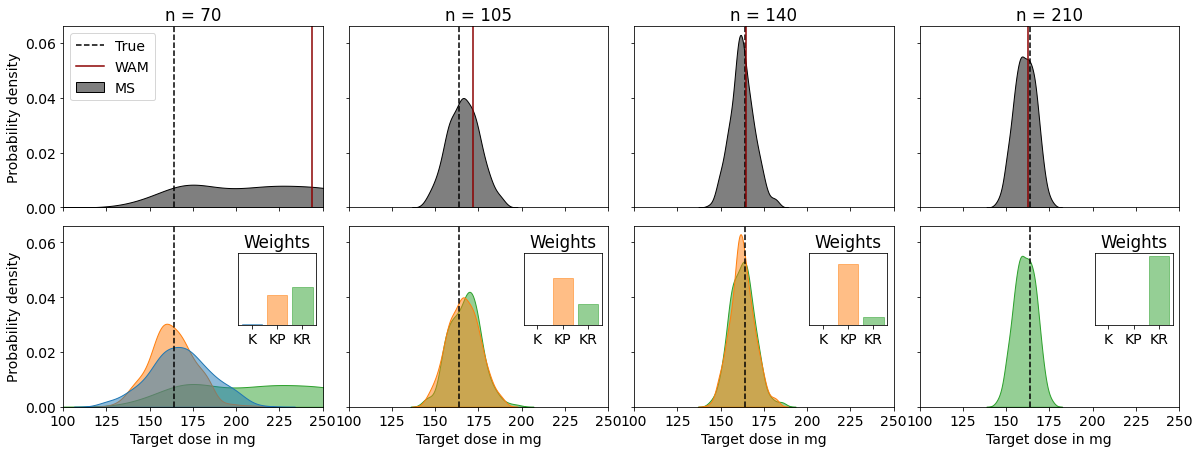

In [32]:
# Config
initial_count = 1E6
target_count = 1E5
count_rel_tolerance = 1
weight_thresh = 0.001
experiment_durations = [10, 15, 20, 30]
n_samples = 300
times = [24]
# doses = np.logspace(4, 6, 1000)
doses = np.linspace(100, 300, 500) * 1E3
models = [human_1, human_2, human_3]

# Define map from model names to stored names
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

# Simulate and fill plot
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fontsize = '14'
plt.rcParams['font.size'] = fontsize
plt.xticks(fontsize=fontsize)
for fig_id, max_time in enumerate(tqdm(max_times)):
    # Load inference results
    parameters, weights = load_inference_data(
        models, model_names, name_map, end_experiment)

    # Estimate distribution of 1-log reduction dose
    # (specific to choice of error model)
    noise = np.random.normal(size=(n_samples))
    target_dose = np.empty(shape=(n_models, n_samples))
    n_doses = len(doses)
    means = np.empty(shape=(n_samples, n_models, n_doses))
    for model_id, model in enumerate(models):
        # Sample parameters from posterior
        posterior = parameters[model_id]
        parameter_samples = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        for sample_id, params in enumerate(parameter_samples):
            # Estimate minimal dose that reaches target reduction
            target_dose[model_id, sample_id], means[sample_id, model_id] = \
                find_dose(
                    model, params, doses, times, noise=noise[sample_id],
                    target=target_count, rel_tolerance=count_rel_tolerance)

    # Average ODE predictions over posterior
    means = np.mean(means, axis=0)

    # Format doses into dataframe
    dfs = []
    for model_id, model in enumerate(['K', 'KP', 'KR']):
        temp = pd.DataFrame(
            data=target_dose[model_id] * 1E-3, columns=['Target dose in mg'])
        temp['Model'] = model
        dfs.append(temp)

    # Estimate time of cure for average of means
    average_of_means = find_dose_weighted_mean_approach(
        means=means, weights=weights, doses=doses, target=target_count,
        rel_tolerance=count_rel_tolerance)

    # Plot model selection solution
    df = dfs[np.argmax(weights)]
    sns.kdeplot(
        data=df, x="Target dose in mg", fill=True, color='black',
        common_norm=False, alpha=.5, linewidth=1, ax=axes[0, fig_id],
        label='MS')
    axes[0, fig_id].axvline(
        x=true_dose, color='black', linestyle='--', label='True')
    axes[0, fig_id].set_title('n = %s' % str(7 * max_time))

    # Plot average of means solution
    df = dfs[np.argmax(weights)]
    axes[0, fig_id].axvline(
        x=average_of_means * 1E-3, color='darkred',
        label='WAM')

    df = []
    colors = []
    for model_id, weight in enumerate(weights):
        if weight < weight_thresh:
            continue
        df.append(dfs[model_id])
        colors.append(sns.color_palette()[model_id])
    df = pd.concat(df, ignore_index=True)
    sns.kdeplot(
        data=df, x="Target dose in mg", hue="Model", fill=True,
        common_norm=False, alpha=.5, linewidth=1, ax=axes[1, fig_id],
        palette=colors, legend=False)
    axes[1, fig_id].axvline(x=true_dose, color='black', linestyle='--')

    # Add weights as insets
    inset_axes = axes[1, fig_id].inset_axes(bounds=[0.675, 0.45, 0.3, 0.4])
    n_models = len(model_names)
    x_pos = np.arange(n_models)
    colors = sns.color_palette()[:n_models]
    inset_axes.bar(
        x_pos, weights, align='center', alpha=0.5, color=colors,
        edgecolor=colors)
    inset_axes.set_xticks(x_pos)
    inset_axes.set_xticklabels(['K', 'KP', 'KR'])
    inset_axes.set_yticks([])
    inset_axes.set_yticklabels([])
    inset_axes.set_title('Weights')
    inset_axes.set_ylim([0, 1.05])


    # Set row titles
    if fig_id == 0:
        axes[0, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[1, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[0, fig_id].legend(loc='upper left')

# Set xlim
axes[0, 0].set_xlim([100, 250])
plt.savefig(
    'images/1log_reduction_dose.pdf', bbox_inches='tight')
plt.show()

2log reduction

In [414]:
true_parameters = [
    1E6,     # Initial bacterial count in CFU/ml
    191,     # Adapated EC50 in ng/ml
    0.77,    # Growth rate in 1/h
    1.61,    # Adapted max. kill rate in 1/h
    0.003,   # Wild type max. kill rate in 1/h
    5E-5,    # Max. mutation rate in 1/h
]

# Simulate models
target_count = 1E4
tolerance = 0.05
doses = np.logspace(4, 6, 1000)
times = [24]
for dose in doses:
    human_true.set_dosing_regimen(dose=dose, start=0, period=12)   # Dose in µg so concentration is ng/mL, dose is 500mg per day Sanchez et al
    sim_true = human_true.simulate(parameters=true_parameters, times=times)[0, 0]

    if (sim_true < target_count):
        assert abs(sim_true - target_count) < target_count * tolerance

        print('True dose is: ', int(dose))
        print('Resulting bacterial count is: ', int(sim_true))

        break

True dose is:  183342
Resulting bacterial count is:  9743


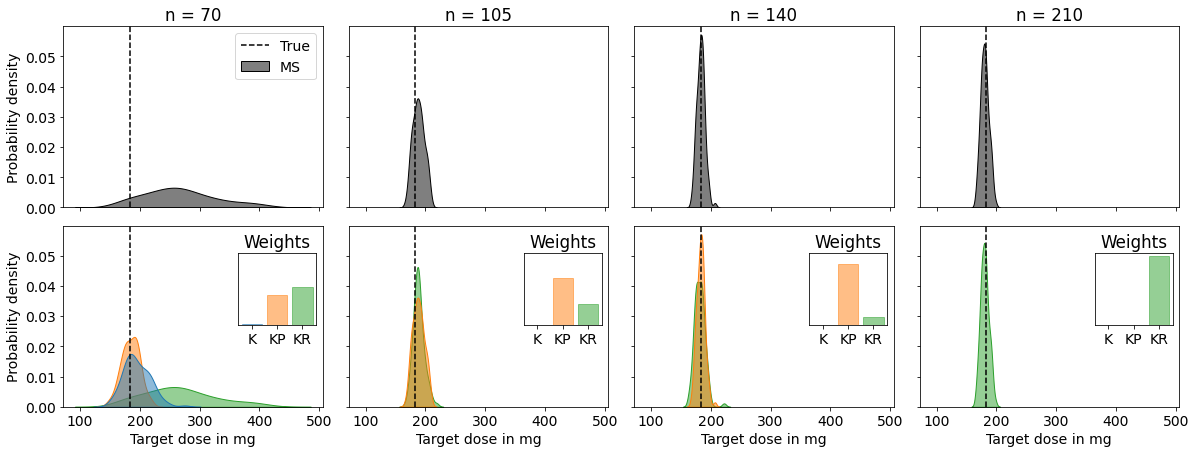

In [418]:
# Config
true_dose = 183  # mg
initial_count = 1E6
target_count = 1E4
count_rel_tolerance = 0.1
weight_thresh = 0.001
max_times = [10, 15, 20, 30]
n_samples = 100
times = [24]
doses = np.logspace(5, 6, 1000)
models = [human_1, human_2, human_3]

# Define map from model names to stored names
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

# Simulate and fill plot
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fontsize = '14'
plt.rcParams['font.size'] = fontsize
plt.xticks(fontsize=fontsize)
for fig_id, max_time in enumerate(tqdm(max_times)):
    # Load inference results
    n_models = 3
    nphi = np.empty(shape=n_models)
    parameters = []
    directory = os.path.dirname(os.getcwd())
    model_names = ['kill_model', 'persistence_model', 'resistance_model']
    for id_m, model in enumerate(model_names):
        # Load inference data
        path = os.path.join(
                directory,
                'posteriors/inference_data_%s_%d.nc' % (model, int(max_time)))
        inference_data = az.from_netcdf(path)
        names = models[id_m].parameters() + ['Sigma log']
        posterior_samples = get_posterior(
                inference_data, names, name_map[id_m])

        # Fix initial count of bacteria
        posterior_samples[:, 0] = initial_count
        parameters.append(posterior_samples)
        nphi[id_m] = inference_data.sample_stats.attrs['elpd AIC']

    # Compute elpd deltas to avoid numerical overflow
    nphi -= np.max(nphi)

    # Compute weights
    weights = np.exp(nphi) / np.sum(np.exp(nphi))

    # Estimate distribution of 1-log reduction dose
    # (specific to choice of error model)
    noise = np.random.normal(size=(n_samples))
    target_dose = []
    means = []
    for model_id, model in enumerate(models):
        # Sample parameters from posterior
        posterior = parameters[model_id]
        parameter_samples = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        td = np.empty(n_samples)
        means_temp = np.empty(shape=(n_samples, len(times)))
        for sample_id, params in enumerate(parameter_samples):
            td[sample_id] = find_dose(
                model=model, parameters=params, doses=doses, times=times,
                noise=noise[sample_id], target=target_count,
                rel_tolerance=count_rel_tolerance)

        target_dose.append(td)

    # Format doses into dataframe
    dfs = []
    for model_id, model in enumerate(['K', 'KP', 'KR']):
        temp = pd.DataFrame(
            data=target_dose[model_id] * 1E-3, columns=['Target dose in mg'])
        temp['Model'] = model
        dfs.append(temp)

    # # Estimate time of cure for average of means
    # pred = np.average(np.array(means), axis=0, weights=weights)
    # average_of_means_time_of_cure = times[np.argmax(is_below_thresh)]
    # if not np.any(is_below_thresh):
    #     average_of_means_time_of_cure = np.inf

    # # Construct probablistic model average
    # samples = []
    # for model_id, df in enumerate(dfs):
    #     n_samples = int(1000 * weights[model_id])
    #     samples.append(
    #         df['Time of cure in hours'].sample(n=n_samples, replace=True))

    # Plot model selection solution
    df = dfs[np.argmax(weights)]
    sns.kdeplot(
        data=df, x="Target dose in mg", fill=True, color='black',
        common_norm=False, alpha=.5, linewidth=1, ax=axes[0, fig_id],
        label='MS')
    axes[0, fig_id].axvline(
        x=true_dose, color='black', linestyle='--', label='True')
    axes[0, fig_id].set_title('n = %s' % str(7 * max_time))

    # # Plot average of means solution
    # df = dfs[np.argmax(weights)]
    # axes[0, fig_id].axvline(
    #     x=average_of_means_time_of_cure, color='darkred',
    #     label='AoM')

    # Plot probabilistic model average solution
    # df = pd.DataFrame(pd.concat(samples, ignore_index=True))
    # sns.kdeplot(
    #     data=df, x="Time of cure in hours", fill=True, color='green',
    #     common_norm=True, alpha=.5, linewidth=1, ax=axes[2, fig_id])
    # axes[2, fig_id].axvline(x=terminal_time, color='black', linestyle='--')
    df = []
    colors = []
    for model_id, weight in enumerate(weights):
        if weight < weight_thresh:
            continue
        df.append(dfs[model_id])
        colors.append(sns.color_palette()[model_id])
    df = pd.concat(df, ignore_index=True)
    sns.kdeplot(
        data=df, x="Target dose in mg", hue="Model", fill=True,
        common_norm=False, alpha=.5, linewidth=1, ax=axes[1, fig_id],
        palette=colors, legend=False)
    axes[1, fig_id].axvline(x=true_dose, color='black', linestyle='--')

    # Add weights as insets
    inset_axes = axes[1, fig_id].inset_axes(bounds=[0.675, 0.45, 0.3, 0.4])
    n_models = len(model_names)
    x_pos = np.arange(n_models)
    colors = sns.color_palette()[:n_models]
    inset_axes.bar(
        x_pos, weights, align='center', alpha=0.5, color=colors,
        edgecolor=colors)
    inset_axes.set_xticks(x_pos)
    inset_axes.set_xticklabels(['K', 'KP', 'KR'])
    inset_axes.set_yticks([])
    inset_axes.set_yticklabels([])
    inset_axes.set_title('Weights')
    inset_axes.set_ylim([0, 1.05])


    # Set row titles
    if fig_id == 0:
        axes[0, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[1, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[0, fig_id].legend(loc='upper right')

# Set xlim
# axes[0, 0].set_xlim([20, 65])
plt.savefig(
    'images/2log_reduction_dose.pdf', bbox_inches='tight')
plt.show()

3log reduction dose

In [421]:
true_parameters = [
    1E6,     # Initial bacterial count in CFU/ml
    191,     # Adapated EC50 in ng/ml
    0.77,    # Growth rate in 1/h
    1.61,    # Adapted max. kill rate in 1/h
    0.003,   # Wild type max. kill rate in 1/h
    5E-5,    # Max. mutation rate in 1/h
]

# Simulate models
target_count = 1E3
tolerance = 0.05
doses = np.logspace(5, 6, 1000)
times = [24]
for dose in doses:
    human_true.set_dosing_regimen(dose=dose, start=0, period=12)   # Dose in µg so concentration is ng/mL, dose is 500mg per day Sanchez et al
    sim_true = human_true.simulate(parameters=true_parameters, times=times)[0, 0]

    if (sim_true < target_count):
        assert abs(sim_true - target_count) < target_count * tolerance

        print('True dose is: ', int(dose))
        print('Resulting bacterial count is: ', int(sim_true))

        break

True dose is:  205263
Resulting bacterial count is:  989


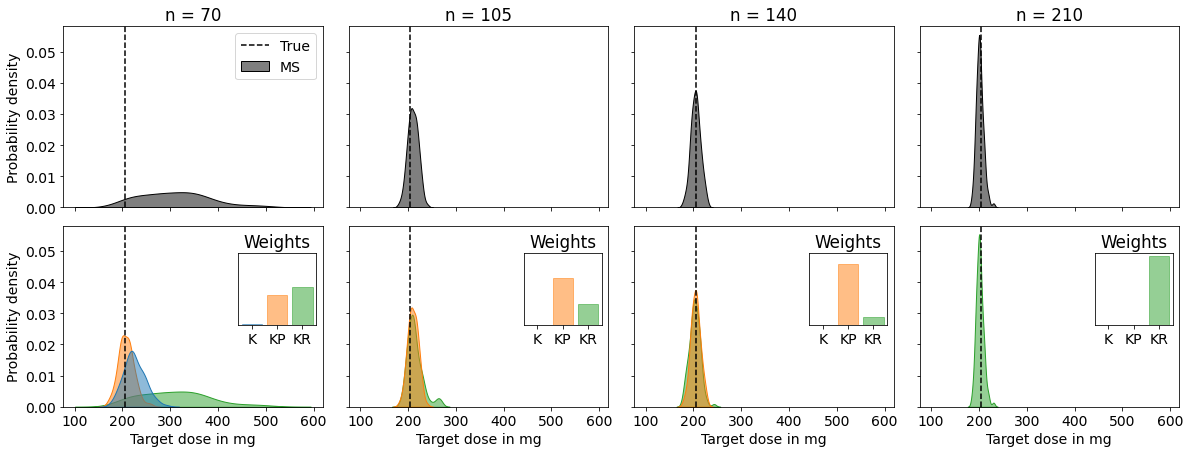

In [422]:
# Config
true_dose = 205  # mg
initial_count = 1E6
target_count = 1E3
count_rel_tolerance = 0.1
weight_thresh = 0.001
max_times = [10, 15, 20, 30]
n_samples = 100
times = [24]
doses = np.logspace(5, 6, 1000)
models = [human_1, human_2, human_3]

# Define map from model names to stored names
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

# Simulate and fill plot
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fontsize = '14'
plt.rcParams['font.size'] = fontsize
plt.xticks(fontsize=fontsize)
for fig_id, max_time in enumerate(tqdm(max_times)):
    # Load inference results
    n_models = 3
    nphi = np.empty(shape=n_models)
    parameters = []
    directory = os.path.dirname(os.getcwd())
    model_names = ['kill_model', 'persistence_model', 'resistance_model']
    for id_m, model in enumerate(model_names):
        # Load inference data
        path = os.path.join(
                directory,
                'posteriors/inference_data_%s_%d.nc' % (model, int(max_time)))
        inference_data = az.from_netcdf(path)
        names = models[id_m].parameters() + ['Sigma log']
        posterior_samples = get_posterior(
                inference_data, names, name_map[id_m])

        # Fix initial count of bacteria
        posterior_samples[:, 0] = initial_count
        parameters.append(posterior_samples)
        nphi[id_m] = inference_data.sample_stats.attrs['elpd AIC']

    # Compute elpd deltas to avoid numerical overflow
    nphi -= np.max(nphi)

    # Compute weights
    weights = np.exp(nphi) / np.sum(np.exp(nphi))

    # Estimate distribution of 1-log reduction dose
    # (specific to choice of error model)
    noise = np.random.normal(size=(n_samples))
    target_dose = []
    means = []
    for model_id, model in enumerate(models):
        # Sample parameters from posterior
        posterior = parameters[model_id]
        parameter_samples = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        td = np.empty(n_samples)
        means_temp = np.empty(shape=(n_samples, len(times)))
        for sample_id, params in enumerate(parameter_samples):
            td[sample_id] = find_dose(
                model=model, parameters=params, doses=doses, times=times,
                noise=noise[sample_id], target=target_count,
                rel_tolerance=count_rel_tolerance)

        target_dose.append(td)

    # Format doses into dataframe
    dfs = []
    for model_id, model in enumerate(['K', 'KP', 'KR']):
        temp = pd.DataFrame(
            data=target_dose[model_id] * 1E-3, columns=['Target dose in mg'])
        temp['Model'] = model
        dfs.append(temp)

    # # Estimate time of cure for average of means
    # pred = np.average(np.array(means), axis=0, weights=weights)
    # average_of_means_time_of_cure = times[np.argmax(is_below_thresh)]
    # if not np.any(is_below_thresh):
    #     average_of_means_time_of_cure = np.inf

    # # Construct probablistic model average
    # samples = []
    # for model_id, df in enumerate(dfs):
    #     n_samples = int(1000 * weights[model_id])
    #     samples.append(
    #         df['Time of cure in hours'].sample(n=n_samples, replace=True))

    # Plot model selection solution
    df = dfs[np.argmax(weights)]
    sns.kdeplot(
        data=df, x="Target dose in mg", fill=True, color='black',
        common_norm=False, alpha=.5, linewidth=1, ax=axes[0, fig_id],
        label='MS')
    axes[0, fig_id].axvline(
        x=true_dose, color='black', linestyle='--', label='True')
    axes[0, fig_id].set_title('n = %s' % str(7 * max_time))

    # # Plot average of means solution
    # df = dfs[np.argmax(weights)]
    # axes[0, fig_id].axvline(
    #     x=average_of_means_time_of_cure, color='darkred',
    #     label='AoM')

    # Plot probabilistic model average solution
    # df = pd.DataFrame(pd.concat(samples, ignore_index=True))
    # sns.kdeplot(
    #     data=df, x="Time of cure in hours", fill=True, color='green',
    #     common_norm=True, alpha=.5, linewidth=1, ax=axes[2, fig_id])
    # axes[2, fig_id].axvline(x=terminal_time, color='black', linestyle='--')
    df = []
    colors = []
    for model_id, weight in enumerate(weights):
        if weight < weight_thresh:
            continue
        df.append(dfs[model_id])
        colors.append(sns.color_palette()[model_id])
    df = pd.concat(df, ignore_index=True)
    sns.kdeplot(
        data=df, x="Target dose in mg", hue="Model", fill=True,
        common_norm=False, alpha=.5, linewidth=1, ax=axes[1, fig_id],
        palette=colors, legend=False)
    axes[1, fig_id].axvline(x=true_dose, color='black', linestyle='--')

    # Add weights as insets
    inset_axes = axes[1, fig_id].inset_axes(bounds=[0.675, 0.45, 0.3, 0.4])
    n_models = len(model_names)
    x_pos = np.arange(n_models)
    colors = sns.color_palette()[:n_models]
    inset_axes.bar(
        x_pos, weights, align='center', alpha=0.5, color=colors,
        edgecolor=colors)
    inset_axes.set_xticks(x_pos)
    inset_axes.set_xticklabels(['K', 'KP', 'KR'])
    inset_axes.set_yticks([])
    inset_axes.set_yticklabels([])
    inset_axes.set_title('Weights')
    inset_axes.set_ylim([0, 1.05])


    # Set row titles
    if fig_id == 0:
        axes[0, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[1, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[0, fig_id].legend(loc='upper right')

# Set xlim
# axes[0, 0].set_xlim([20, 65])
plt.savefig(
    'images/3log_reduction_dose.pdf', bbox_inches='tight')
plt.show()

4-fold reduction

In [431]:
true_parameters = [
    1E6,     # Initial bacterial count in CFU/ml
    191,     # Adapated EC50 in ng/ml
    0.77,    # Growth rate in 1/h
    1.61,    # Adapted max. kill rate in 1/h
    0.003,   # Wild type max. kill rate in 1/h
    5E-5,    # Max. mutation rate in 1/h
]

# Simulate models
target_count = 1E2
tolerance = 0.05
doses = np.logspace(5, 6, 1000)
times = [24]
for dose in doses:
    human_true.set_dosing_regimen(dose=dose, start=0, period=12)   # Dose in µg so concentration is ng/mL, dose is 500mg per day Sanchez et al
    sim_true = human_true.simulate(parameters=true_parameters, times=times)[0, 0]

    if (sim_true < target_count):
        assert abs(sim_true - target_count) < target_count * tolerance

        print('True dose is: ', int(dose))
        print('Resulting bacterial count is: ', int(sim_true))

        break

True dose is:  238439
Resulting bacterial count is:  99


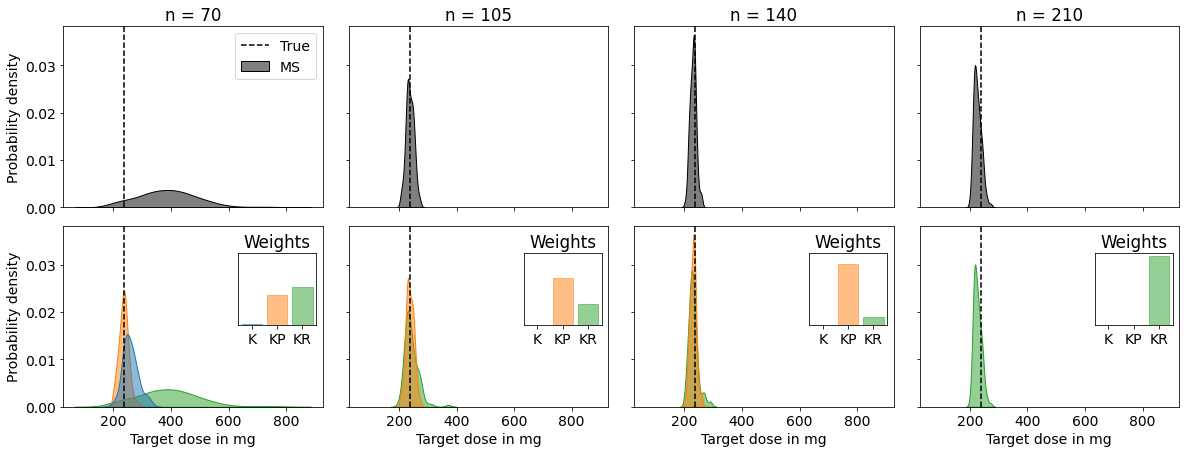

In [433]:
# Config
true_dose = 238  # mg
initial_count = 1E6
target_count = 1E2
count_rel_tolerance = 0.1
weight_thresh = 0.001
max_times = [10, 15, 20, 30]
n_samples = 100
times = [24]
doses = np.logspace(5, 6, 1000)
models = [human_1, human_2, human_3]

# Define map from model names to stored names
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

# Simulate and fill plot
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fontsize = '14'
plt.rcParams['font.size'] = fontsize
plt.xticks(fontsize=fontsize)
for fig_id, max_time in enumerate(tqdm(max_times)):
    # Load inference results
    n_models = 3
    nphi = np.empty(shape=n_models)
    parameters = []
    directory = os.path.dirname(os.getcwd())
    model_names = ['kill_model', 'persistence_model', 'resistance_model']
    for id_m, model in enumerate(model_names):
        # Load inference data
        path = os.path.join(
                directory,
                'posteriors/inference_data_%s_%d.nc' % (model, int(max_time)))
        inference_data = az.from_netcdf(path)
        names = models[id_m].parameters() + ['Sigma log']
        posterior_samples = get_posterior(
                inference_data, names, name_map[id_m])

        # Fix initial count of bacteria
        posterior_samples[:, 0] = initial_count
        parameters.append(posterior_samples)
        nphi[id_m] = inference_data.sample_stats.attrs['elpd AIC']

    # Compute elpd deltas to avoid numerical overflow
    nphi -= np.max(nphi)

    # Compute weights
    weights = np.exp(nphi) / np.sum(np.exp(nphi))

    # Estimate distribution of 1-log reduction dose
    # (specific to choice of error model)
    noise = np.random.normal(size=(n_samples))
    target_dose = []
    means = []
    for model_id, model in enumerate(models):
        # Sample parameters from posterior
        posterior = parameters[model_id]
        parameter_samples = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        td = np.empty(n_samples)
        means_temp = np.empty(shape=(n_samples, len(times)))
        for sample_id, params in enumerate(parameter_samples):
            td[sample_id] = find_dose(
                model=model, parameters=params, doses=doses, times=times,
                noise=noise[sample_id], target=target_count,
                rel_tolerance=count_rel_tolerance)

        target_dose.append(td)

    # Format doses into dataframe
    dfs = []
    for model_id, model in enumerate(['K', 'KP', 'KR']):
        temp = pd.DataFrame(
            data=target_dose[model_id] * 1E-3, columns=['Target dose in mg'])
        temp['Model'] = model
        dfs.append(temp)

    # # Estimate time of cure for average of means
    # pred = np.average(np.array(means), axis=0, weights=weights)
    # average_of_means_time_of_cure = times[np.argmax(is_below_thresh)]
    # if not np.any(is_below_thresh):
    #     average_of_means_time_of_cure = np.inf

    # # Construct probablistic model average
    # samples = []
    # for model_id, df in enumerate(dfs):
    #     n_samples = int(1000 * weights[model_id])
    #     samples.append(
    #         df['Time of cure in hours'].sample(n=n_samples, replace=True))

    # Plot model selection solution
    df = dfs[np.argmax(weights)]
    sns.kdeplot(
        data=df, x="Target dose in mg", fill=True, color='black',
        common_norm=False, alpha=.5, linewidth=1, ax=axes[0, fig_id],
        label='MS')
    axes[0, fig_id].axvline(
        x=true_dose, color='black', linestyle='--', label='True')
    axes[0, fig_id].set_title('n = %s' % str(7 * max_time))

    # # Plot average of means solution
    # df = dfs[np.argmax(weights)]
    # axes[0, fig_id].axvline(
    #     x=average_of_means_time_of_cure, color='darkred',
    #     label='AoM')

    # Plot probabilistic model average solution
    # df = pd.DataFrame(pd.concat(samples, ignore_index=True))
    # sns.kdeplot(
    #     data=df, x="Time of cure in hours", fill=True, color='green',
    #     common_norm=True, alpha=.5, linewidth=1, ax=axes[2, fig_id])
    # axes[2, fig_id].axvline(x=terminal_time, color='black', linestyle='--')
    df = []
    colors = []
    for model_id, weight in enumerate(weights):
        if weight < weight_thresh:
            continue
        df.append(dfs[model_id])
        colors.append(sns.color_palette()[model_id])
    df = pd.concat(df, ignore_index=True)
    sns.kdeplot(
        data=df, x="Target dose in mg", hue="Model", fill=True,
        common_norm=False, alpha=.5, linewidth=1, ax=axes[1, fig_id],
        palette=colors, legend=False)
    axes[1, fig_id].axvline(x=true_dose, color='black', linestyle='--')

    # Add weights as insets
    inset_axes = axes[1, fig_id].inset_axes(bounds=[0.675, 0.45, 0.3, 0.4])
    n_models = len(model_names)
    x_pos = np.arange(n_models)
    colors = sns.color_palette()[:n_models]
    inset_axes.bar(
        x_pos, weights, align='center', alpha=0.5, color=colors,
        edgecolor=colors)
    inset_axes.set_xticks(x_pos)
    inset_axes.set_xticklabels(['K', 'KP', 'KR'])
    inset_axes.set_yticks([])
    inset_axes.set_yticklabels([])
    inset_axes.set_title('Weights')
    inset_axes.set_ylim([0, 1.05])


    # Set row titles
    if fig_id == 0:
        axes[0, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[1, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[0, fig_id].legend(loc='upper right')

# Set xlim
# axes[0, 0].set_xlim([20, 65])
plt.savefig(
    'images/4log_reduction_dose.pdf', bbox_inches='tight')
plt.show()

5 fold reduction dose

In [434]:
true_parameters = [
    1E6,     # Initial bacterial count in CFU/ml
    191,     # Adapated EC50 in ng/ml
    0.77,    # Growth rate in 1/h
    1.61,    # Adapted max. kill rate in 1/h
    0.003,   # Wild type max. kill rate in 1/h
    5E-5,    # Max. mutation rate in 1/h
]

# Simulate models
target_count = 1E1
tolerance = 0.05
doses = np.logspace(5, 6, 1000)
times = [24]
for dose in doses:
    human_true.set_dosing_regimen(dose=dose, start=0, period=12)   # Dose in µg so concentration is ng/mL, dose is 500mg per day Sanchez et al
    sim_true = human_true.simulate(parameters=true_parameters, times=times)[0, 0]

    if (sim_true < target_count):
        assert abs(sim_true - target_count) < target_count * tolerance

        print('True dose is: ', int(dose))
        print('Resulting bacterial count is: ', int(sim_true))

        break

True dose is:  300939
Resulting bacterial count is:  9


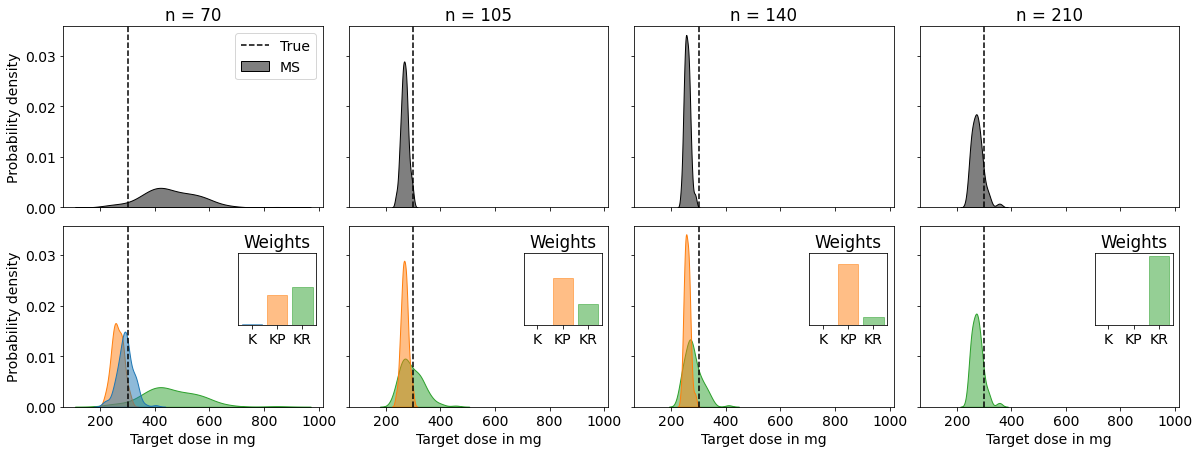

In [435]:
# Config
true_dose = 301  # mg
initial_count = 1E6
target_count = 1E1
count_rel_tolerance = 0.1
weight_thresh = 0.001
max_times = [10, 15, 20, 30]
n_samples = 100
times = [24]
doses = np.logspace(5, 6, 1000)
models = [human_1, human_2, human_3]

# Define map from model names to stored names
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

# Simulate and fill plot
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fontsize = '14'
plt.rcParams['font.size'] = fontsize
plt.xticks(fontsize=fontsize)
for fig_id, max_time in enumerate(tqdm(max_times)):
    # Load inference results
    n_models = 3
    nphi = np.empty(shape=n_models)
    parameters = []
    directory = os.path.dirname(os.getcwd())
    model_names = ['kill_model', 'persistence_model', 'resistance_model']
    for id_m, model in enumerate(model_names):
        # Load inference data
        path = os.path.join(
                directory,
                'posteriors/inference_data_%s_%d.nc' % (model, int(max_time)))
        inference_data = az.from_netcdf(path)
        names = models[id_m].parameters() + ['Sigma log']
        posterior_samples = get_posterior(
                inference_data, names, name_map[id_m])

        # Fix initial count of bacteria
        posterior_samples[:, 0] = initial_count
        parameters.append(posterior_samples)
        nphi[id_m] = inference_data.sample_stats.attrs['elpd AIC']

    # Compute elpd deltas to avoid numerical overflow
    nphi -= np.max(nphi)

    # Compute weights
    weights = np.exp(nphi) / np.sum(np.exp(nphi))

    # Estimate distribution of 1-log reduction dose
    # (specific to choice of error model)
    noise = np.random.normal(size=(n_samples))
    target_dose = []
    means = []
    for model_id, model in enumerate(models):
        # Sample parameters from posterior
        posterior = parameters[model_id]
        parameter_samples = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        td = np.empty(n_samples)
        means_temp = np.empty(shape=(n_samples, len(times)))
        for sample_id, params in enumerate(parameter_samples):
            td[sample_id] = find_dose(
                model=model, parameters=params, doses=doses, times=times,
                noise=noise[sample_id], target=target_count,
                rel_tolerance=count_rel_tolerance)

        target_dose.append(td)

    # Format doses into dataframe
    dfs = []
    for model_id, model in enumerate(['K', 'KP', 'KR']):
        temp = pd.DataFrame(
            data=target_dose[model_id] * 1E-3, columns=['Target dose in mg'])
        temp['Model'] = model
        dfs.append(temp)

    # # Estimate time of cure for average of means
    # pred = np.average(np.array(means), axis=0, weights=weights)
    # average_of_means_time_of_cure = times[np.argmax(is_below_thresh)]
    # if not np.any(is_below_thresh):
    #     average_of_means_time_of_cure = np.inf

    # # Construct probablistic model average
    # samples = []
    # for model_id, df in enumerate(dfs):
    #     n_samples = int(1000 * weights[model_id])
    #     samples.append(
    #         df['Time of cure in hours'].sample(n=n_samples, replace=True))

    # Plot model selection solution
    df = dfs[np.argmax(weights)]
    sns.kdeplot(
        data=df, x="Target dose in mg", fill=True, color='black',
        common_norm=False, alpha=.5, linewidth=1, ax=axes[0, fig_id],
        label='MS')
    axes[0, fig_id].axvline(
        x=true_dose, color='black', linestyle='--', label='True')
    axes[0, fig_id].set_title('n = %s' % str(7 * max_time))

    # # Plot average of means solution
    # df = dfs[np.argmax(weights)]
    # axes[0, fig_id].axvline(
    #     x=average_of_means_time_of_cure, color='darkred',
    #     label='AoM')

    # Plot probabilistic model average solution
    # df = pd.DataFrame(pd.concat(samples, ignore_index=True))
    # sns.kdeplot(
    #     data=df, x="Time of cure in hours", fill=True, color='green',
    #     common_norm=True, alpha=.5, linewidth=1, ax=axes[2, fig_id])
    # axes[2, fig_id].axvline(x=terminal_time, color='black', linestyle='--')
    df = []
    colors = []
    for model_id, weight in enumerate(weights):
        if weight < weight_thresh:
            continue
        df.append(dfs[model_id])
        colors.append(sns.color_palette()[model_id])
    df = pd.concat(df, ignore_index=True)
    sns.kdeplot(
        data=df, x="Target dose in mg", hue="Model", fill=True,
        common_norm=False, alpha=.5, linewidth=1, ax=axes[1, fig_id],
        palette=colors, legend=False)
    axes[1, fig_id].axvline(x=true_dose, color='black', linestyle='--')

    # Add weights as insets
    inset_axes = axes[1, fig_id].inset_axes(bounds=[0.675, 0.45, 0.3, 0.4])
    n_models = len(model_names)
    x_pos = np.arange(n_models)
    colors = sns.color_palette()[:n_models]
    inset_axes.bar(
        x_pos, weights, align='center', alpha=0.5, color=colors,
        edgecolor=colors)
    inset_axes.set_xticks(x_pos)
    inset_axes.set_xticklabels(['K', 'KP', 'KR'])
    inset_axes.set_yticks([])
    inset_axes.set_yticklabels([])
    inset_axes.set_title('Weights')
    inset_axes.set_ylim([0, 1.05])


    # Set row titles
    if fig_id == 0:
        axes[0, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[1, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[0, fig_id].legend(loc='upper right')

# Set xlim
# axes[0, 0].set_xlim([20, 65])
plt.savefig(
    'images/5log_reduction_dose.pdf', bbox_inches='tight')
plt.show()

6 fold reduction

In [436]:
true_parameters = [
    1E6,     # Initial bacterial count in CFU/ml
    191,     # Adapated EC50 in ng/ml
    0.77,    # Growth rate in 1/h
    1.61,    # Adapted max. kill rate in 1/h
    0.003,   # Wild type max. kill rate in 1/h
    5E-5,    # Max. mutation rate in 1/h
]

# Simulate models
target_count = 1E0
tolerance = 0.05
doses = np.logspace(5, 6, 1000)
times = [24]
for dose in doses:
    human_true.set_dosing_regimen(dose=dose, start=0, period=12)   # Dose in µg so concentration is ng/mL, dose is 500mg per day Sanchez et al
    sim_true = human_true.simulate(parameters=true_parameters, times=times)[0, 0]

    if (sim_true < target_count):
        assert abs(sim_true - target_count) < target_count * tolerance

        print('True dose is: ', int(dose))
        print('Resulting bacterial count is: ', int(sim_true))

        break

True dose is:  401424
Resulting bacterial count is:  0


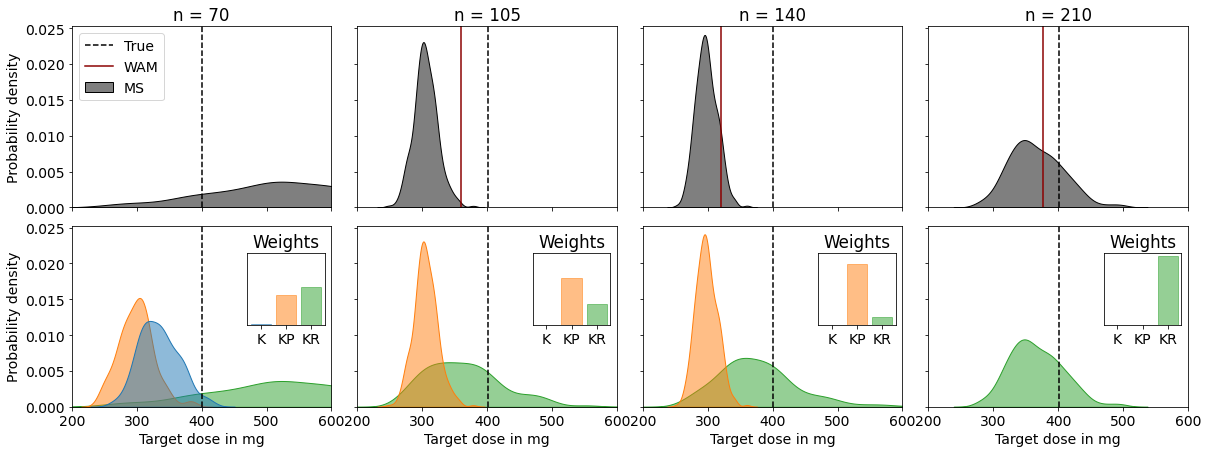

In [33]:
# Config
true_dose = 401  # mg
initial_count = 1E6
target_count = 1E0
count_rel_tolerance = 0.1
weight_thresh = 0.001
max_times = [10, 15, 20, 30]
n_samples = 300
times = [24]
# doses = np.logspace(5, 6, 1000)
doses = np.linspace(200, 700, 500) * 1E3
models = [human_1, human_2, human_3]

# Define map from model names to stored names
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

# Simulate and fill plot
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fontsize = '14'
plt.rcParams['font.size'] = fontsize
plt.xticks(fontsize=fontsize)
for fig_id, max_time in enumerate(tqdm(max_times)):
    # Load inference results
    n_models = 3
    nphi = np.empty(shape=n_models)
    parameters = []
    directory = os.path.dirname(os.getcwd())
    model_names = ['kill_model', 'persistence_model', 'resistance_model']
    for id_m, model in enumerate(model_names):
        # Load inference data
        path = os.path.join(
                directory,
                'posteriors/inference_data_%s_%d.nc' % (model, int(max_time)))
        inference_data = az.from_netcdf(path)
        names = models[id_m].parameters() + ['Sigma log']
        posterior_samples = get_posterior(
                inference_data, names, name_map[id_m])

        # Fix initial count of bacteria
        posterior_samples[:, 0] = initial_count
        parameters.append(posterior_samples)
        nphi[id_m] = inference_data.sample_stats.attrs['elpd AIC']

    # Compute elpd deltas to avoid numerical overflow
    nphi -= np.max(nphi)

    # Compute weights
    weights = np.exp(nphi) / np.sum(np.exp(nphi))

    # Estimate distribution of 1-log reduction dose
    # (specific to choice of error model)
    noise = np.random.normal(size=(n_samples))
    target_dose = np.empty(shape=(n_models, n_samples))
    n_doses = len(doses)
    means = np.empty(shape=(n_samples, n_models, n_doses))
    for model_id, model in enumerate(models):
        # Sample parameters from posterior
        posterior = parameters[model_id]
        parameter_samples = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        for sample_id, params in enumerate(parameter_samples):
            # Estimate minimal dose that reaches target reduction
            target_dose[model_id, sample_id], means[sample_id, model_id] = \
                find_dose(
                    model, params, doses, times, noise=noise[sample_id],
                    target=target_count, rel_tolerance=count_rel_tolerance)

    # Average ODE predictions over posterior
    means = np.mean(means, axis=0)

    # Format doses into dataframe
    dfs = []
    for model_id, model in enumerate(['K', 'KP', 'KR']):
        temp = pd.DataFrame(
            data=target_dose[model_id] * 1E-3, columns=['Target dose in mg'])
        temp['Model'] = model
        dfs.append(temp)

    # Estimate time of cure for average of means
    average_of_means = find_dose_weighted_mean_approach(
        means=means, weights=weights, doses=doses, target=target_count,
        rel_tolerance=count_rel_tolerance)

    # Plot model selection solution
    df = dfs[np.argmax(weights)]
    sns.kdeplot(
        data=df, x="Target dose in mg", fill=True, color='black',
        common_norm=False, alpha=.5, linewidth=1, ax=axes[0, fig_id],
        label='MS')
    axes[0, fig_id].axvline(
        x=true_dose, color='black', linestyle='--', label='True')
    axes[0, fig_id].set_title('n = %s' % str(7 * max_time))

    # Plot average of means solution
    df = dfs[np.argmax(weights)]
    axes[0, fig_id].axvline(
        x=average_of_means * 1E-3, color='darkred',
        label='WAM')

    df = []
    colors = []
    for model_id, weight in enumerate(weights):
        if weight < weight_thresh:
            continue
        df.append(dfs[model_id])
        colors.append(sns.color_palette()[model_id])
    df = pd.concat(df, ignore_index=True)
    sns.kdeplot(
        data=df, x="Target dose in mg", hue="Model", fill=True,
        common_norm=False, alpha=.5, linewidth=1, ax=axes[1, fig_id],
        palette=colors, legend=False)
    axes[1, fig_id].axvline(x=true_dose, color='black', linestyle='--')

    # Add weights as insets
    inset_axes = axes[1, fig_id].inset_axes(bounds=[0.675, 0.45, 0.3, 0.4])
    n_models = len(model_names)
    x_pos = np.arange(n_models)
    colors = sns.color_palette()[:n_models]
    inset_axes.bar(
        x_pos, weights, align='center', alpha=0.5, color=colors,
        edgecolor=colors)
    inset_axes.set_xticks(x_pos)
    inset_axes.set_xticklabels(['K', 'KP', 'KR'])
    inset_axes.set_yticks([])
    inset_axes.set_yticklabels([])
    inset_axes.set_title('Weights')
    inset_axes.set_ylim([0, 1.05])


    # Set row titles
    if fig_id == 0:
        axes[0, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[1, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[0, fig_id].legend(loc='upper left')

# Set xlim
axes[0, 0].set_xlim([200, 600])
plt.savefig(
    'images/6log_reduction_dose.pdf', bbox_inches='tight')
plt.show()

Let's try to predict 3 fold reduction dose within 72 hours

In [428]:
true_parameters = [
    1E6,     # Initial bacterial count in CFU/ml
    191,     # Adapated EC50 in ng/ml
    0.77,    # Growth rate in 1/h
    1.61,    # Adapted max. kill rate in 1/h
    0.003,   # Wild type max. kill rate in 1/h
    5E-5,    # Max. mutation rate in 1/h
]

# Simulate models
target_count = 1E3
tolerance = 0.1
doses = np.logspace(5, 6, 1000)
times = [72]
for dose in doses:
    human_true.set_dosing_regimen(dose=dose, start=0, period=12)   # Dose in µg so concentration is ng/mL, dose is 500mg per day Sanchez et al
    sim_true = human_true.simulate(parameters=true_parameters, times=times)[0, 0]

    if (sim_true < target_count):
        assert abs(sim_true - target_count) < target_count * tolerance

        print('True dose is: ', int(dose))
        print('Resulting bacterial count is: ', int(sim_true))

        break

True dose is:  154949
Resulting bacterial count is:  900


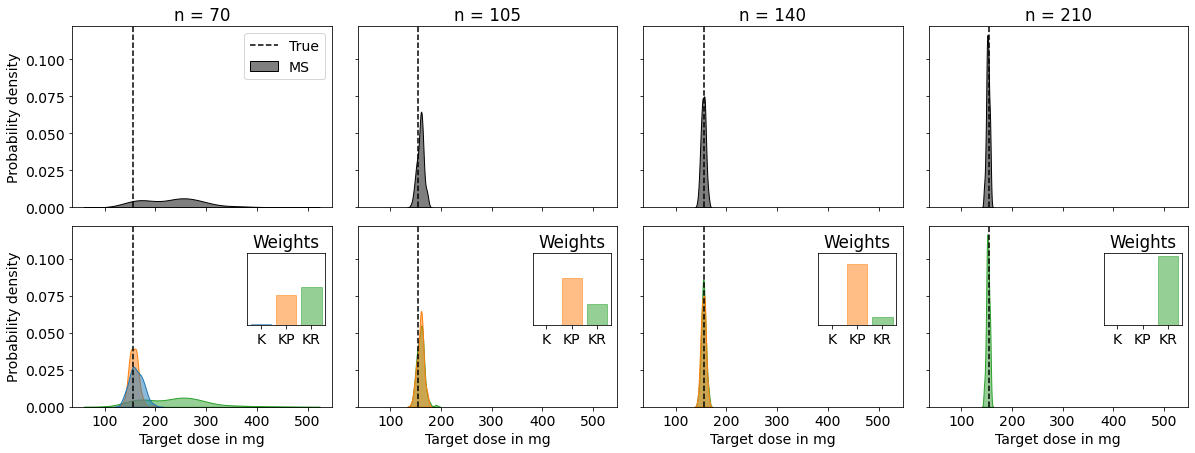

In [430]:
# Config
true_dose = 155  # mg
initial_count = 1E6
target_count = 1E3
count_rel_tolerance = 0.2
weight_thresh = 0.001
max_times = [10, 15, 20, 30]
n_samples = 100
times = [72]
doses = np.logspace(5, 6, 1000)
models = [human_1, human_2, human_3]

# Define map from model names to stored names
name_map = [
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'EC 50 in ng/ml': 'pooled_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Max. kill rate in 1/h': 'pooled_max_kill_rate',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Death rate in 1/h': 'pooled_death_rate',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Kill rate in ml/ng/h': 'pooled_kill_rate',
        'Transition rate to dividing in 1/h': 'pooled_rate_to_dividing',
        'Transition rate to non-dividing in ml/ng/h': 'pooled_rate_to_nondividing',
        'Sigma log': 'pooled_sigma_log'},
    {
        'Initial bacterial count in CFU/ml': 'pooled_initial_bacterial_count',
        'Adapted EC 50 in ng/ml': 'pooled_adapted_ec50',
        'Growth rate in 1/h': 'pooled_growth_rate',
        'Adapted max. kill rate in 1/h': 'pooled_adapted_max_kill_rate',
        'Wild type kill rate in ml/ng/h': 'pooled_wild_type_kill_rate',
        'Mutation rate in ml/ng/h': 'pooled_mutation_rate',
        'Sigma log': 'pooled_sigma_log'}
]

# Simulate and fill plot
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fontsize = '14'
plt.rcParams['font.size'] = fontsize
plt.xticks(fontsize=fontsize)
for fig_id, max_time in enumerate(tqdm(max_times)):
    # Load inference results
    n_models = 3
    nphi = np.empty(shape=n_models)
    parameters = []
    directory = os.path.dirname(os.getcwd())
    model_names = ['kill_model', 'persistence_model', 'resistance_model']
    for id_m, model in enumerate(model_names):
        # Load inference data
        path = os.path.join(
                directory,
                'posteriors/inference_data_%s_%d.nc' % (model, int(max_time)))
        inference_data = az.from_netcdf(path)
        names = models[id_m].parameters() + ['Sigma log']
        posterior_samples = get_posterior(
                inference_data, names, name_map[id_m])

        # Fix initial count of bacteria
        posterior_samples[:, 0] = initial_count
        parameters.append(posterior_samples)
        nphi[id_m] = inference_data.sample_stats.attrs['elpd AIC']

    # Compute elpd deltas to avoid numerical overflow
    nphi -= np.max(nphi)

    # Compute weights
    weights = np.exp(nphi) / np.sum(np.exp(nphi))

    # Estimate distribution of 1-log reduction dose
    # (specific to choice of error model)
    noise = np.random.normal(size=(n_samples))
    target_dose = []
    means = []
    for model_id, model in enumerate(models):
        # Sample parameters from posterior
        posterior = parameters[model_id]
        parameter_samples = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        td = np.empty(n_samples)
        means_temp = np.empty(shape=(n_samples, len(times)))
        for sample_id, params in enumerate(parameter_samples):
            td[sample_id] = find_dose(
                model=model, parameters=params, doses=doses, times=times,
                noise=noise[sample_id], target=target_count,
                rel_tolerance=count_rel_tolerance)

        target_dose.append(td)

    # Format doses into dataframe
    dfs = []
    for model_id, model in enumerate(['K', 'KP', 'KR']):
        temp = pd.DataFrame(
            data=target_dose[model_id] * 1E-3, columns=['Target dose in mg'])
        temp['Model'] = model
        dfs.append(temp)

    # # Estimate time of cure for average of means
    # pred = np.average(np.array(means), axis=0, weights=weights)
    # average_of_means_time_of_cure = times[np.argmax(is_below_thresh)]
    # if not np.any(is_below_thresh):
    #     average_of_means_time_of_cure = np.inf

    # # Construct probablistic model average
    # samples = []
    # for model_id, df in enumerate(dfs):
    #     n_samples = int(1000 * weights[model_id])
    #     samples.append(
    #         df['Time of cure in hours'].sample(n=n_samples, replace=True))

    # Plot model selection solution
    df = dfs[np.argmax(weights)]
    sns.kdeplot(
        data=df, x="Target dose in mg", fill=True, color='black',
        common_norm=False, alpha=.5, linewidth=1, ax=axes[0, fig_id],
        label='MS')
    axes[0, fig_id].axvline(
        x=true_dose, color='black', linestyle='--', label='True')
    axes[0, fig_id].set_title('n = %s' % str(7 * max_time))

    # # Plot average of means solution
    # df = dfs[np.argmax(weights)]
    # axes[0, fig_id].axvline(
    #     x=average_of_means_time_of_cure, color='darkred',
    #     label='AoM')

    # Plot probabilistic model average solution
    # df = pd.DataFrame(pd.concat(samples, ignore_index=True))
    # sns.kdeplot(
    #     data=df, x="Time of cure in hours", fill=True, color='green',
    #     common_norm=True, alpha=.5, linewidth=1, ax=axes[2, fig_id])
    # axes[2, fig_id].axvline(x=terminal_time, color='black', linestyle='--')
    df = []
    colors = []
    for model_id, weight in enumerate(weights):
        if weight < weight_thresh:
            continue
        df.append(dfs[model_id])
        colors.append(sns.color_palette()[model_id])
    df = pd.concat(df, ignore_index=True)
    sns.kdeplot(
        data=df, x="Target dose in mg", hue="Model", fill=True,
        common_norm=False, alpha=.5, linewidth=1, ax=axes[1, fig_id],
        palette=colors, legend=False)
    axes[1, fig_id].axvline(x=true_dose, color='black', linestyle='--')

    # Add weights as insets
    inset_axes = axes[1, fig_id].inset_axes(bounds=[0.675, 0.45, 0.3, 0.4])
    n_models = len(model_names)
    x_pos = np.arange(n_models)
    colors = sns.color_palette()[:n_models]
    inset_axes.bar(
        x_pos, weights, align='center', alpha=0.5, color=colors,
        edgecolor=colors)
    inset_axes.set_xticks(x_pos)
    inset_axes.set_xticklabels(['K', 'KP', 'KR'])
    inset_axes.set_yticks([])
    inset_axes.set_yticklabels([])
    inset_axes.set_title('Weights')
    inset_axes.set_ylim([0, 1.05])


    # Set row titles
    if fig_id == 0:
        axes[0, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[1, fig_id].set_ylabel('Probability density', fontsize=fontsize)
        axes[0, fig_id].legend(loc='upper right')

# Set xlim
# axes[0, 0].set_xlim([20, 65])
plt.savefig(
    'images/3log_reduction_dose_72h.pdf', bbox_inches='tight')
plt.show()